Возьмем временной ряд о продажах компании и построим для него модель ARIMA

In [1]:
import pandas as pd

In [19]:
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')

In [3]:
import numpy as np

In [4]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
series = sales_of_company_x["Count"]

In [21]:
def test_stationarity(timeseries): #будем проводить тест на стационарность и смотреть на число p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [22]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'): #помимо теста, будем анализировать графики автокорреляции acf и pacf
    test_stationarity(y)                                #и график квантиль-квантиль qqplot
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [23]:
series

0     154
1      96
2      73
3      49
4      36
     ... 
72    628
73    308
74    324
75    248
76    272
Name: Count, Length: 77, dtype: int64

In [10]:
from scipy.stats import boxcox #данные прологарифмируем, чтобы сделать временной ряд более походим на стационарный

#series = boxcox(series, 0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

aic: 853.71501 | order: (4, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                 -1.910458
p-value                         0.327157
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


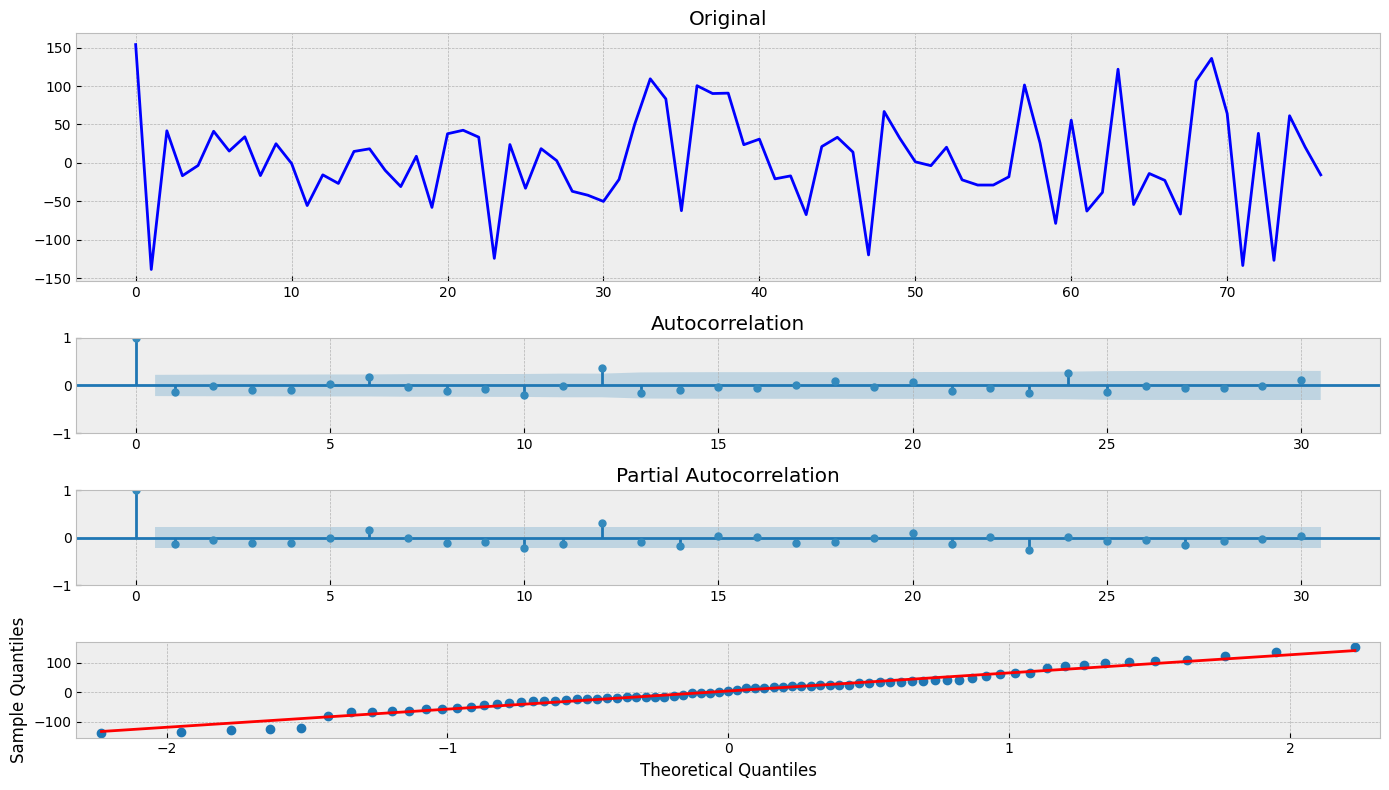

In [24]:
#создаем функцию для просмотра остатков после применения модели ARIMA

best_aic = np.inf #лучший критерий
best_order = None #лучший порядок
best_mdl = None #лучшая модель

for i in range(5): #создаем три перебора в соотвествии с наличием трех порядков в ARIMA
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j), trend='n').fit() #инициализируем модель и применяем ее на данных
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

#print(best_mdl)

tsplot(best_mdl.resid, lags=30)

В идеале временный ряд остатков должен быть стационарным. Что можно сказать о нашем ряде?

Итак, график по внешнему виду похож на шум. Для временного ряда остатков p-value меньше 0,5, а значит тест считает ряд стационарным.

По графику автокорреляций также можно судить о стационарности данных, так как он сразу падает.

При этом график квантиль-квантиль не лежит полностью на красной линии. Если бы лежал, то можно было судить о нормальном распределении данных.

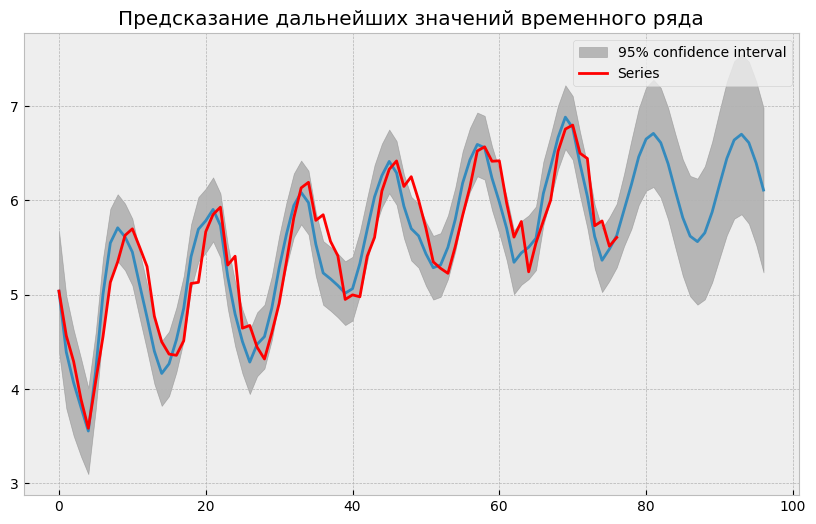

In [18]:
#Посмотрим, как модель может предсказать временный ряд

from statsmodels.graphics.tsaplots import plot_predict

with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.title('Предсказание дальнейших значений временного ряда')
    plt.show()